In [1]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

In [ ]:
SLA = {
    "eMBB": {"throughput": 50, "latency": 20},
    "URLLC": {"throughput": 5, "latency": 1},
    "mMTC": {"throughput": 0.1, "latency": 100}
}

SLICES = ["eMBB", "URLLC", "mMTC"]
TOTAL_RBS = 100
MAX_STEPS = 200


class NetworkSlicingEnv(gym.Env):
    metadata = {"render_modes": []}

    def __init__(self):
        super().__init__()

        self.action_space = spaces.Box(
            low=0.0, high=1.0, shape=(3,), dtype=np.float32
        )

        self.observation_space = spaces.Box(
            low=0.0, high=2000.0, shape=(6,), dtype=np.float32
        )

        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        self.queues = {
            "eMBB": 500.0,
            "URLLC": 50.0,
            "mMTC": 20.0
        }

        self.traffic_rate = {
            "eMBB": 30,
            "URLLC": 5,
            "mMTC": 1
        }

        self.sla_violations = {s: 0 for s in SLICES}
        self.steps = 0

        return self._get_obs(), {}

    def step(self, action):
        self.steps += 1

        action = np.clip(action, 0, 1)
        if np.sum(action) == 0:
            action = np.ones(3) / 3
        action = action / np.sum(action)

        rb_alloc = {
            s: action[i] * TOTAL_RBS for i, s in enumerate(SLICES)
        }

        reward = 0
        info = {}

        for s in SLICES:
            served = rb_alloc[s] * self._spectral_efficiency(s)
            self.queues[s] = max(
                0, self.queues[s] + self.traffic_rate[s] - served
            )

            latency = self._compute_latency(self.queues[s], served)
            throughput = served

            info[s] = {"throughput": throughput, "latency": latency}

            if self._sla_violation(s, throughput, latency):
                self.sla_violations[s] += 1
                reward -= self._sla_penalty(s)
            else:
                reward += throughput * 0.02

        terminated = self.steps >= MAX_STEPS
        truncated = False

        return self._get_obs(), reward, terminated, truncated, info

    def _get_obs(self):
        return np.array([
            self.queues["eMBB"],
            self.queues["URLLC"],
            self.queues["mMTC"],
            self.traffic_rate["eMBB"],
            self.traffic_rate["URLLC"],
            self.traffic_rate["mMTC"]
        ], dtype=np.float32)

    def _spectral_efficiency(self, s):
        return {"eMBB": 1.0, "URLLC": 0.5, "mMTC": 0.2}[s]

    def _compute_latency(self, queue, served):
        return 1e3 if served == 0 else queue / served

    def _sla_violation(self, s, th, lat):
        return th < SLA[s]["throughput"] or lat > SLA[s]["latency"]

    def _sla_penalty(self, s):
        return {"URLLC": 10, "eMBB": 3, "mMTC": 1}[s]

In [4]:
env = DummyVecEnv([lambda: NetworkSlicingEnv()])

In [5]:
model = PPO(
    policy="MlpPolicy",
    env=env,
    learning_rate=3e-4,
    gamma=0.99,
    n_steps=2048,
    batch_size=256,
    verbose=1
)

model.learn(total_timesteps=100_000)

Using cuda device


c:\Users\User\.conda\envs\test\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 735  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011922859 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.26       |
|    explained_variance   | -0.00119    |
|    learning_rate        | 0.0003      |
|    loss                 | 3.68e+03    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0127     |
|    std                  | 1           |
|    value_loss           | 7.86e+03    |
----------------------------------

In [6]:
env = NetworkSlicingEnv()
obs, _ = env.reset()

throughput_log = {s: [] for s in SLICES}

for _ in range(200):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)

    for s in SLICES:
        throughput_log[s].append(info[s]["throughput"])

    if terminated:
        break

print("Average Throughput:")
for s in SLICES:
    print(f"{s}: {np.mean(throughput_log[s]):.2f}")

print("\nSLA Violations:")
print(env.sla_violations)

Average Throughput:
eMBB: 0.00
URLLC: 34.50
mMTC: 6.20

SLA Violations:
{'eMBB': 200, 'URLLC': 0, 'mMTC': 0}


In [7]:
import matplotlib.pyplot as plt
import numpy as np

In [8]:
def moving_average(x, window=10):
    return np.convolve(x, np.ones(window)/window, mode="valid")

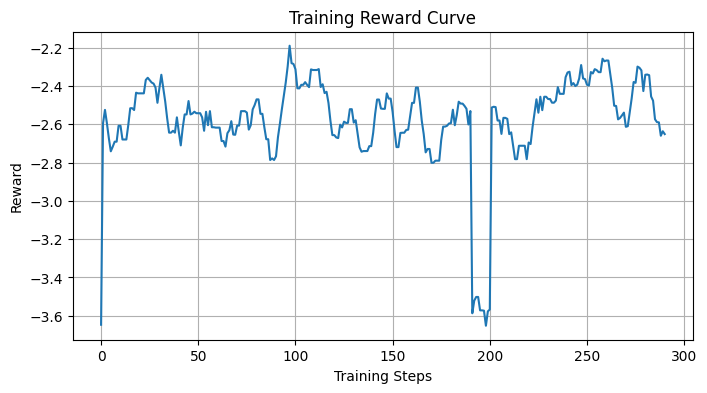

In [17]:
reward_log = []

env = NetworkSlicingEnv()
obs, _ = env.reset()

for _ in range(300):
    action, _ = model.predict(obs)
    obs, reward, terminated, truncated, _ = env.step(action)
    reward_log.append(reward)

    if terminated:
        obs, _ = env.reset()

plt.figure(figsize=(8,4))
plt.plot(moving_average(reward_log))
plt.xlabel("Training Steps")
plt.ylabel("Reward")
plt.title("Training Reward Curve")
plt.grid()
plt.show()

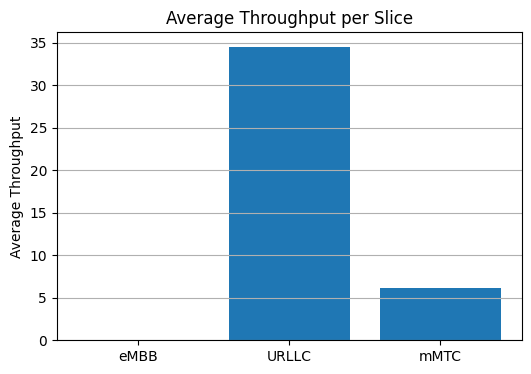

In [11]:
env = NetworkSlicingEnv()
obs, _ = env.reset()

throughput = {s: [] for s in SLICES}

for _ in range(200):
    action, _ = model.predict(obs, deterministic=True)
    obs, _, terminated, truncated, info = env.step(action)

    for s in SLICES:
        throughput[s].append(info[s]["throughput"])

    if terminated:
        break


plt.figure(figsize=(6,4))
plt.bar(throughput.keys(), [np.mean(throughput[s]) for s in throughput])
plt.ylabel("Average Throughput")
plt.title("Average Throughput per Slice")
plt.grid(axis="y")
plt.show()

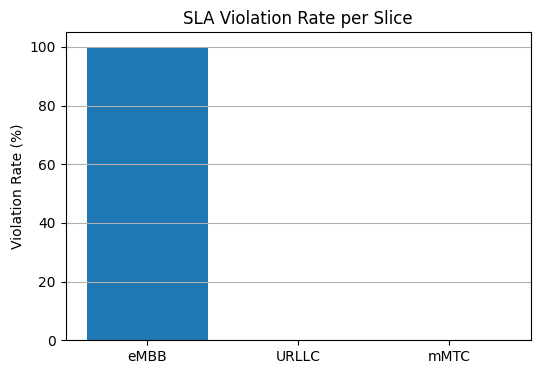

In [13]:
total_steps = env.steps
violations = env.sla_violations

sla_violation_rate = {
    s: violations[s] / total_steps * 100
    for s in SLICES
}

plt.figure(figsize=(6,4))
plt.bar(sla_violation_rate.keys(), sla_violation_rate.values())
plt.ylabel("Violation Rate (%)")
plt.title("SLA Violation Rate per Slice")
plt.grid(axis="y")
plt.show()

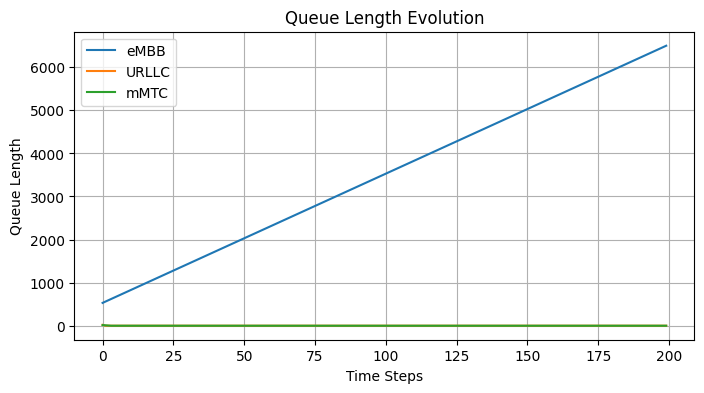

In [14]:
env = NetworkSlicingEnv()
obs, _ = env.reset()

queue_log = {s: [] for s in SLICES}

for _ in range(200):
    action, _ = model.predict(obs, deterministic=True)
    obs, _, terminated, truncated, _ = env.step(action)

    for s in SLICES:
        queue_log[s].append(env.queues[s])

    if terminated:
        break


plt.figure(figsize=(8,4))
for s in SLICES:
    plt.plot(queue_log[s], label=s)

plt.xlabel("Time Steps")
plt.ylabel("Queue Length")
plt.title("Queue Length Evolution")
plt.legend()
plt.grid()
plt.show()

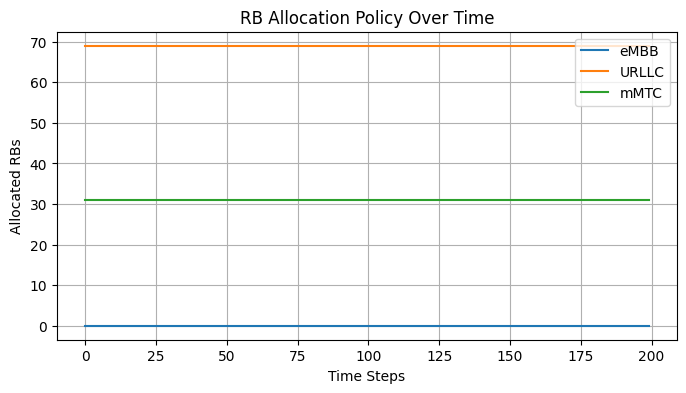

In [15]:
env = NetworkSlicingEnv()
obs, _ = env.reset()

rb_log = {s: [] for s in SLICES}

for _ in range(200):
    action, _ = model.predict(obs, deterministic=True)
    action = action / np.sum(action)

    for i, s in enumerate(SLICES):
        rb_log[s].append(action[i] * TOTAL_RBS)

    obs, _, terminated, truncated, _ = env.step(action)

    if terminated:
        break


plt.figure(figsize=(8,4))
for s in SLICES:
    plt.plot(rb_log[s], label=s)

plt.xlabel("Time Steps")
plt.ylabel("Allocated RBs")
plt.title("RB Allocation Policy Over Time")
plt.legend()
plt.grid()
plt.show()

In [16]:
def run_policy(env, policy_fn, steps=200):
    obs, _ = env.reset()
    rewards = []

    for _ in range(steps):
        action = policy_fn(obs)
        obs, reward, terminated, truncated, _ = env.step(action)
        rewards.append(reward)
        if terminated:
            break

    return np.mean(rewards)

fixed_policy = lambda obs: np.array([0.5, 0.3, 0.2])

baseline_reward = run_policy(NetworkSlicingEnv(), fixed_policy)
rl_reward = run_policy(NetworkSlicingEnv(), lambda obs: model.predict(obs)[0])

print("Baseline Reward:", baseline_reward)
print("RL Reward:", rl_reward)

Baseline Reward: 1.2255000000000005
RL Reward: -2.435401427425444
